<a href="https://colab.research.google.com/github/cinumell/stock_price_prediction_Deep_Learning/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Prediction 



1.   Amazon - AMZN
2.   Apple - AAPL
3.   Microsoft - MSFT
4. Google - GOOGL
5. Tesla - TSLA
6. Oracle - ORCL


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

TensorFlow version: 2.10.0
Num GPUs Available:  1
Num CPUs Available:  1


/var/folders/p6/vpj9j15x7774phthzn6s023m0000gn/T/ipykernel_40796/3493795175.py:17: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")


Base case error for open = 4.52184337519583
Base case error for close = 4.49583764100604
Base case error for high = 4.467202612774115
Base case error for low = 4.540209260577311


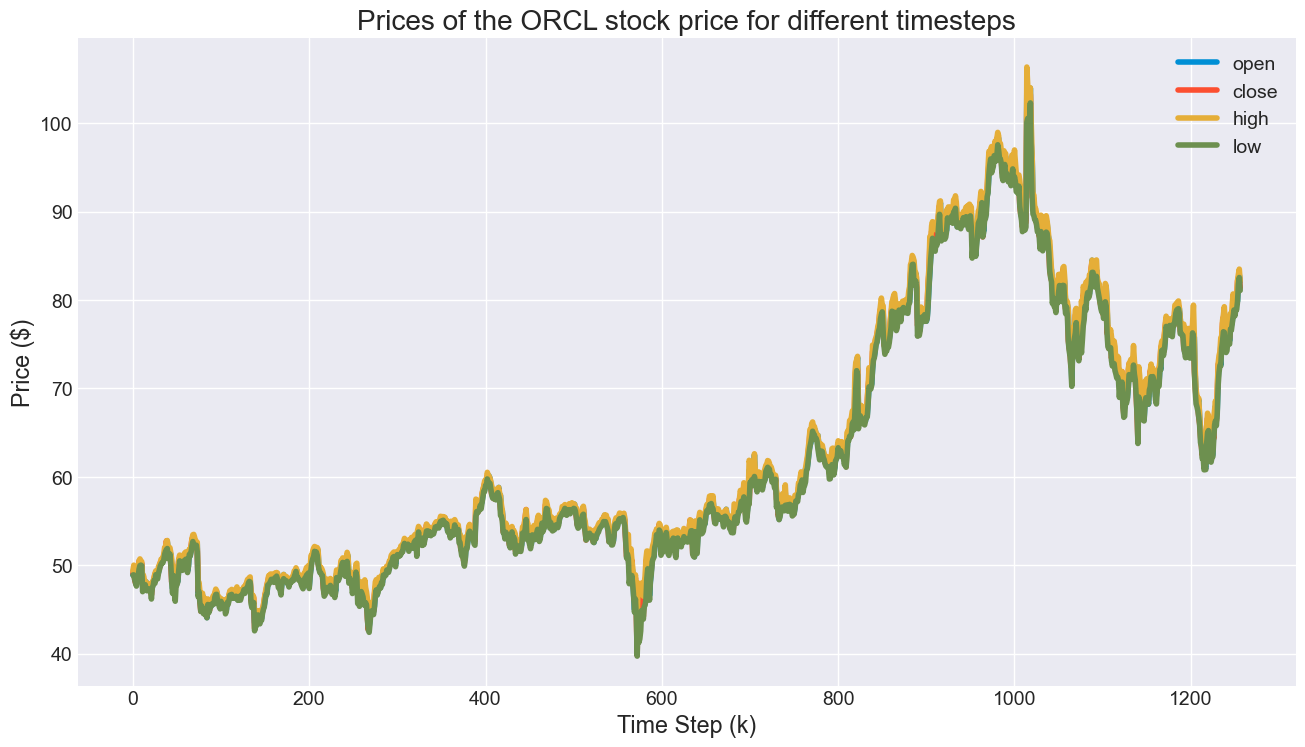

In [ ]:
# Dataset download
import pandas_datareader as pr
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

step = 70 # time step
company = 'ORCL'
price_type = 'close'


#plt.style.use('fivethirtyeight')
plt.style.use('seaborn-darkgrid')

fig,ax = plt.subplots(figsize=(14,8))
data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")
data.to_csv(company+'.csv')

data = pd.read_csv(company+'.csv')
# Baseline calculation
Base_errors = []

for types in ['open','close','high','low']:

  Price = data[types]
  Means = list()

  for i in range(len(Price) - step):
    Means.append(sum(Price[i:i+step])/step)  

  Error = math.sqrt(mean_squared_error(Price[step:],Means))
  Base_errors.append(Error)   
  print("Base case error for",types,"=",Error)    
  ax.plot(Price,label=types)
 
#Customize
ax.set(title=f'Prices of the {company} stock price for different timesteps', 
       ylabel='Price ($)',
       xlabel='Time Step (k)')
ax.legend()
Price = data[price_type]

In [ ]:
data.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,ORCL,2022-11-21 00:00:00+00:00,79.82,80.100,78.900,79.57,5235554,79.82,80.100,78.900,79.57,5235554,0.0,1.0
1253,ORCL,2022-11-22 00:00:00+00:00,82.12,82.210,79.830,79.89,8796154,82.12,82.210,79.830,79.89,8796154,0.0,1.0
1254,ORCL,2022-11-23 00:00:00+00:00,82.56,82.920,81.780,82.12,6347899,82.56,82.920,81.780,82.12,6347899,0.0,1.0
1255,ORCL,2022-11-25 00:00:00+00:00,82.72,83.485,82.535,82.85,2754876,82.72,83.485,82.535,82.85,2754876,0.0,1.0
1256,ORCL,2022-11-28 00:00:00+00:00,81.39,82.140,81.070,82.11,5113103,81.39,82.140,81.070,82.11,5113103,0.0,1.0


In [ ]:
# MinMax Scalimg
import numpy as np
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler(feature_range=(0,1))
Price = mms.fit_transform(np.array(Price).reshape(-1,1))

# Dataset split into train and test sets

train_size = int(len(Price)*0.80)
test_size = len(Price)-train_size
train_data,test_data = Price[0:train_size,:],Price[train_size:len(Price),:1]
train_size, test_size

(1005, 252)

In [ ]:
# Converting data to timeseries input

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

time_step = step
trainX, trainY = create_dataset(train_data, time_step)
testX, testY = create_dataset(test_data, time_step)

print(trainX.shape), print(trainY.shape)
print(testX.shape), print(testY.shape)

trainX_2d = trainX
testX_2d = testX

trainX = trainX.reshape(trainX.shape[0],trainX.shape[1] , 1)
testX = testX.reshape(testX.shape[0],testX.shape[1] , 1)

(934, 70)
(934,)
(181, 70)
(181,)


# RandomForestRegressor Ensembler Model

In [ ]:
# Import the RandomForestRegressor model class from the ensemble module
from sklearn.ensemble import RandomForestRegressor

# Setup random seed
np.random.seed(42)

# Institate and fit the model (on the training set)
model = RandomForestRegressor()
model.fit(trainX_2d, trainY)

RandomForestRegressor()

# Stacked LSTM model

In [ ]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

lstm = Sequential()
lstm.add(LSTM(128, return_sequences=True, input_shape= (step, 1)))
lstm.add(LSTM(64, return_sequences=False))
lstm.add(Dense(25))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 70, 128)           66560     
                                                                 
 lstm_51 (LSTM)              (None, 64)                49408     
                                                                 
 dense_50 (Dense)            (None, 25)                1625      
                                                                 
 dense_51 (Dense)            (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


2022-11-29 00:55:13.745321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:55:13.871754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:55:14.035964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:55:14.320711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:55:14.669353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0313

2022-11-29 00:55:17.007577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:55:17.066674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:55:17.187706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 5s 185ms/step - loss: 0.0313 - val_loss: 0.0125
Epoch 2/100
15/15 [==============================] - 1s 52ms/step - loss: 0.0031 - val_loss: 0.0058
Epoch 3/100
15/15 [==============================] - 1s 49ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 4/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 5/100
15/15 [==============================] - 1s 44ms/step - loss: 9.4905e-04 - val_loss: 0.0028
Epoch 6/100
15/15 [==============================] - 1s 49ms/step - loss: 9.3973e-04 - val_loss: 0.0027
Epoch 7/100
15/15 [==============================] - 1s 44ms/step - loss: 9.0271e-04 - val_loss: 0.0027
Epoch 8/100
15/15 [==============================] - 1s 44ms/step - loss: 8.6434e-04 - val_loss: 0.0027
Epoch 9/100
15/15 [==============================] - 1s 41ms/step - loss: 8.5084e-04 - val_loss: 0.0028
Epoch 10/100
15/15 [==============================] - 1s 42ms/step - loss: 8.7821e-04 - val

Epoch 79/100
15/15 [==============================] - 1s 41ms/step - loss: 3.2068e-04 - val_loss: 6.8867e-04
Epoch 80/100
15/15 [==============================] - 1s 41ms/step - loss: 2.8934e-04 - val_loss: 9.9558e-04
Epoch 81/100
15/15 [==============================] - 1s 41ms/step - loss: 3.1470e-04 - val_loss: 0.0011
Epoch 82/100
15/15 [==============================] - 1s 40ms/step - loss: 3.2733e-04 - val_loss: 7.6169e-04
Epoch 83/100
15/15 [==============================] - 1s 41ms/step - loss: 2.7473e-04 - val_loss: 6.4963e-04
Epoch 84/100
15/15 [==============================] - 1s 40ms/step - loss: 2.7868e-04 - val_loss: 6.5855e-04
Epoch 85/100
15/15 [==============================] - 1s 40ms/step - loss: 2.7764e-04 - val_loss: 8.7571e-04
Epoch 86/100
15/15 [==============================] - 1s 41ms/step - loss: 2.9011e-04 - val_loss: 7.6980e-04
Epoch 87/100
15/15 [==============================] - 1s 42ms/step - loss: 3.1310e-04 - val_loss: 8.5272e-04
Epoch 88/100
15/15 [===

# Simple RNN

In [ ]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense

rnn = Sequential()
rnn.add(LSTM(128, return_sequences=True, input_shape= (step, 1)))
rnn.add(LSTM(64, return_sequences=False))
rnn.add(Dense(25))
rnn.add(Dense(1))
rnn.compile(optimizer='adam', loss='mean_squared_error')
rnn.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 70, 128)           66560     
                                                                 
 lstm_53 (LSTM)              (None, 64)                49408     
                                                                 
 dense_52 (Dense)            (None, 25)                1625      
                                                                 
 dense_53 (Dense)            (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rnn.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


2022-11-29 00:56:21.175522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:56:21.313154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:56:21.478238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:56:21.818487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:56:22.081123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0292

2022-11-29 00:56:24.294918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:56:24.342759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:56:24.487290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 5s 182ms/step - loss: 0.0292 - val_loss: 0.0102
Epoch 2/100
15/15 [==============================] - 1s 48ms/step - loss: 0.0038 - val_loss: 0.0056
Epoch 3/100
15/15 [==============================] - 1s 43ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 4/100
15/15 [==============================] - 1s 45ms/step - loss: 9.2756e-04 - val_loss: 0.0027
Epoch 5/100
15/15 [==============================] - 1s 46ms/step - loss: 8.8286e-04 - val_loss: 0.0026
Epoch 6/100
15/15 [==============================] - 1s 42ms/step - loss: 8.5083e-04 - val_loss: 0.0027
Epoch 7/100
15/15 [==============================] - 1s 43ms/step - loss: 8.3926e-04 - val_loss: 0.0026
Epoch 8/100
15/15 [==============================] - 1s 47ms/step - loss: 8.3755e-04 - val_loss: 0.0026
Epoch 9/100
15/15 [==============================] - 1s 43ms/step - loss: 8.2163e-04 - val_loss: 0.0025
Epoch 10/100
15/15 [==============================] - 1s 42ms/step - loss: 8.2296e-04 -

15/15 [==============================] - 1s 41ms/step - loss: 3.6880e-04 - val_loss: 8.6192e-04
Epoch 80/100
15/15 [==============================] - 1s 40ms/step - loss: 3.8895e-04 - val_loss: 8.5697e-04
Epoch 81/100
15/15 [==============================] - 1s 42ms/step - loss: 3.4472e-04 - val_loss: 8.4801e-04
Epoch 82/100
15/15 [==============================] - 1s 41ms/step - loss: 3.4409e-04 - val_loss: 8.9581e-04
Epoch 83/100
15/15 [==============================] - 1s 40ms/step - loss: 3.5092e-04 - val_loss: 8.3152e-04
Epoch 84/100
15/15 [==============================] - 1s 40ms/step - loss: 3.9845e-04 - val_loss: 8.5147e-04
Epoch 85/100
15/15 [==============================] - 1s 40ms/step - loss: 3.6856e-04 - val_loss: 8.4350e-04
Epoch 86/100
15/15 [==============================] - 1s 41ms/step - loss: 3.3688e-04 - val_loss: 8.3118e-04
Epoch 87/100
15/15 [==============================] - 1s 40ms/step - loss: 3.2471e-04 - val_loss: 8.1830e-04
Epoch 88/100
15/15 [============

# GRU

In [ ]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

gru = Sequential()
gru.add(LSTM(128, return_sequences=True, input_shape= (step, 1)))
gru.add(LSTM(64, return_sequences=False))
gru.add(Dense(25))
gru.add(Dense(1))
gru.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
gru.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 70, 128)           66560     
                                                                 
 lstm_55 (LSTM)              (None, 64)                49408     
                                                                 
 dense_54 (Dense)            (None, 25)                1625      
                                                                 
 dense_55 (Dense)            (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gru.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


2022-11-29 00:57:28.115932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:57:28.252068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:57:28.411277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:57:28.682416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:57:29.007901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0651

2022-11-29 00:57:31.118835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:57:31.165964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:57:31.307986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 6s 175ms/step - loss: 0.0651 - val_loss: 0.0344
Epoch 2/100
15/15 [==============================] - 1s 52ms/step - loss: 0.0282 - val_loss: 0.0072
Epoch 3/100
15/15 [==============================] - 1s 49ms/step - loss: 0.0124 - val_loss: 0.0063
Epoch 4/100
15/15 [==============================] - 1s 42ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 5/100
15/15 [==============================] - 1s 41ms/step - loss: 0.0012 - val_loss: 0.0062
Epoch 6/100
15/15 [==============================] - 1s 42ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 7/100
15/15 [==============================] - 1s 40ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 8/100
15/15 [==============================] - 1s 42ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 9/100
15/15 [==============================] - 1s 41ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 10/100
15/15 [==============================] - 1s 40ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 11/1

15/15 [==============================] - 1s 42ms/step - loss: 0.0010 - val_loss: 0.0039
Epoch 83/100
15/15 [==============================] - 1s 41ms/step - loss: 9.8401e-04 - val_loss: 0.0039
Epoch 84/100
15/15 [==============================] - 1s 42ms/step - loss: 9.7362e-04 - val_loss: 0.0042
Epoch 85/100
15/15 [==============================] - 1s 41ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 86/100
15/15 [==============================] - 1s 40ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 87/100
15/15 [==============================] - 1s 41ms/step - loss: 9.9898e-04 - val_loss: 0.0040
Epoch 88/100
15/15 [==============================] - 1s 44ms/step - loss: 9.9316e-04 - val_loss: 0.0039
Epoch 89/100
15/15 [==============================] - 1s 44ms/step - loss: 9.8477e-04 - val_loss: 0.0038
Epoch 90/100
15/15 [==============================] - 1s 42ms/step - loss: 9.7460e-04 - val_loss: 0.0039
Epoch 91/100
15/15 [==============================] - 1s 42ms/step - loss: 9.706

2022-11-29 00:58:33.948303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:58:33.998489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/30 [>.............................] - ETA: 19s

2022-11-29 00:58:34.166870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 54ms/step


2022-11-29 00:58:35.787814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:58:35.833173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:58:35.984481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 50ms/step


2022-11-29 00:58:37.565581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 00:58:37.611050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/30 [>.............................] - ETA: 18s

2022-11-29 00:58:37.789309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 58ms/step
Shape of LSTM test (181, 1)
Shape of RNN test (181, 1)
Shape of GRU test (181, 1)
Shape of RandomForestRegressor test (181,)
[76.65]
[52.32]
[52.63301]
[76.00902]
Train data error for LSTM model = 0.9840985478425195
Test data error for LSTM model= 1.5333031424010042
----------------------------------------------------------------------
Train data error for RNN model = 1.0967378838292792
Test data error for RNN model= 1.7413458268984587
----------------------------------------------------------------------
Train data error for GRU model = 1.9745933600342556
Test data error for GRU model= 3.932184021485279
----------------------------------------------------------------------
Train data error for RF model = 60.52269645024058
Test data error for RF model= 73.39486628377306


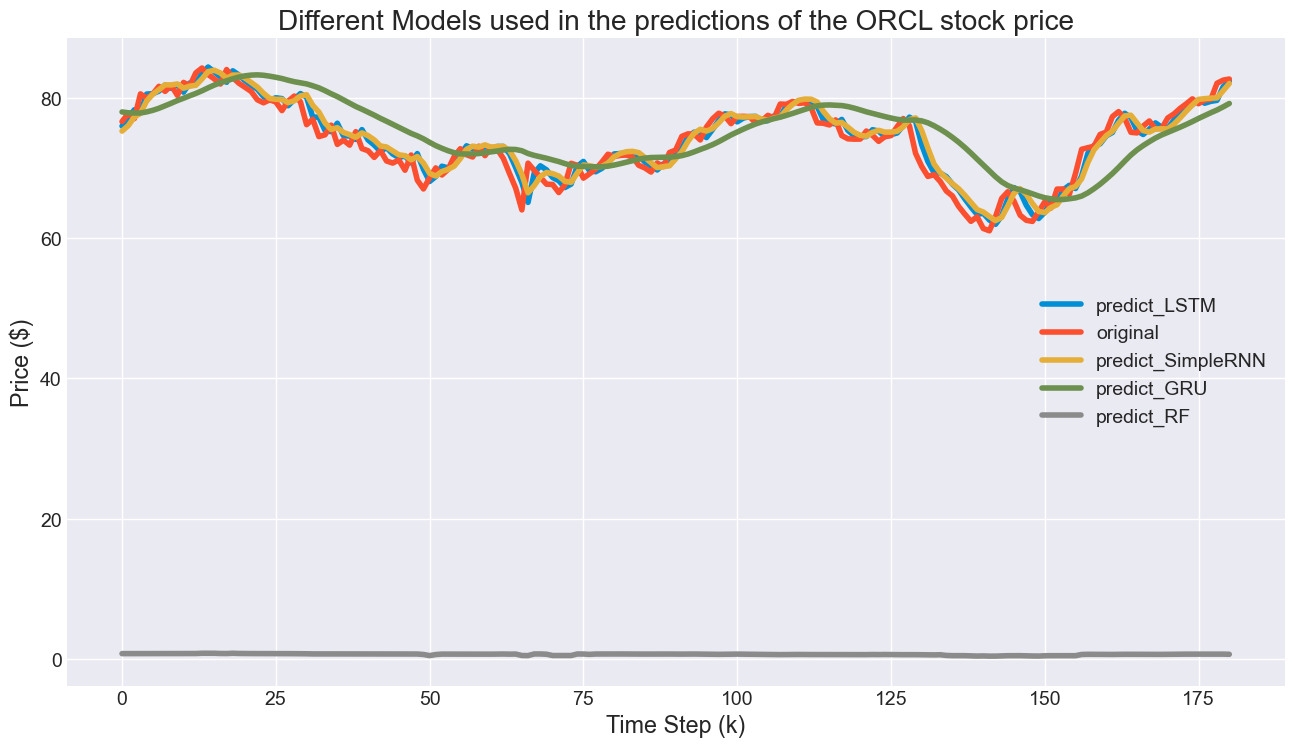

In [ ]:
# Prediction and error calculation for lstm

train_predict_lstm = lstm.predict(trainX)
test_predict_lstm = lstm.predict(testX)

train_predict_rnn = rnn.predict(trainX)
test_predict_rnn = rnn.predict(testX)

train_predict_gru = gru.predict(trainX)
test_predict_gru = gru.predict(testX)

train_predict_rf = model.predict(trainX_2d)
test_predict_rf = model.predict(testX_2d)


print("Shape of LSTM test",test_predict_lstm.shape)
print("Shape of RNN test",test_predict_rnn.shape)
print("Shape of GRU test",test_predict_gru.shape)
print("Shape of RandomForestRegressor test",test_predict_rf.shape)

testY_lstm = testY.reshape(test_size-step-1,1)
trainY_lstm = trainY.reshape(train_size-step-1,1)

testY_rnn = testY.reshape(test_size-step-1,1)
trainY_rnn = trainY.reshape(train_size-step-1,1)

testY_gru = testY.reshape(test_size-step-1,1)
trainY_gru = trainY.reshape(train_size-step-1,1)

testY_rf = testY.reshape(test_size-step-1,1)
trainY_rf = trainY.reshape(train_size-step-1,1)

testY_lstm = mms.inverse_transform(testY_lstm)
trainY_lstm = mms.inverse_transform(trainY_lstm)

testY_rnn = mms.inverse_transform(testY_rnn)
trainY_rnn = mms.inverse_transform(trainY_rnn)

testY_gru = mms.inverse_transform(testY_gru)
trainY_gru = mms.inverse_transform(trainY_gru)

testY_rf = mms.inverse_transform(testY_rf)
trainY_rf = mms.inverse_transform(trainY_rf)

print(testY_lstm[0])
print(trainY_lstm[0])

train_predict_lstm = mms.inverse_transform(train_predict_lstm)
test_predict_lstm = mms.inverse_transform(test_predict_lstm)
train_predict_rnn = mms.inverse_transform(train_predict_rnn)
test_predict_rnn = mms.inverse_transform(test_predict_rnn)
train_predict_gru = mms.inverse_transform(train_predict_gru)
test_predict_gru = mms.inverse_transform(test_predict_gru)

print(train_predict_lstm[0])
print(test_predict_lstm[0])

print("Train data error for LSTM model =",math.sqrt(mean_squared_error(trainY_lstm,train_predict_lstm)))
print("Test data error for LSTM model=",math.sqrt(mean_squared_error(testY_lstm,test_predict_lstm)))
print("----------------------------------------------------------------------")
print("Train data error for RNN model =",math.sqrt(mean_squared_error(trainY_rnn,train_predict_rnn)))
print("Test data error for RNN model=",math.sqrt(mean_squared_error(testY_rnn,test_predict_rnn)))
print("----------------------------------------------------------------------")
print("Train data error for GRU model =",math.sqrt(mean_squared_error(trainY_gru,train_predict_gru)))
print("Test data error for GRU model=",math.sqrt(mean_squared_error(testY_gru,test_predict_gru)))
print("----------------------------------------------------------------------")
print("Train data error for RF model =",math.sqrt(mean_squared_error(trainY_rf,train_predict_rf)))
print("Test data error for RF model=",math.sqrt(mean_squared_error(testY_rf,test_predict_rf)))

#plt.style.use('fivethirtyeight')
plt.style.use('seaborn-darkgrid')
fig,ax = plt.subplots(figsize=(14,8))
#Customize
ax.set(title=f'Different Models used in the predictions of the {company} stock price', 
       xlabel='Time Step (k)',
       ylabel='Price ($)')
ax.plot(test_predict_lstm,label = "predict_LSTM")
ax.plot(testY_lstm,label = "original")
ax.plot(test_predict_rnn,label = "predict_SimpleRNN")
ax.plot(test_predict_gru,label = "predict_GRU")
ax.plot(test_predict_rf, label ="predict_RF")
ax.legend()